# Deep Learning for Computer Vision:  Assignment 2


## Computer Science: COMS W 4995 004


## Due: February 27, 2018

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units affects the solution.

e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.237878,-0.099275,1.0
1,0.183164,0.394355,0.0
2,0.105153,0.850634,1.0
3,0.079044,1.157975,1.0
4,-0.049224,0.811017,1.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

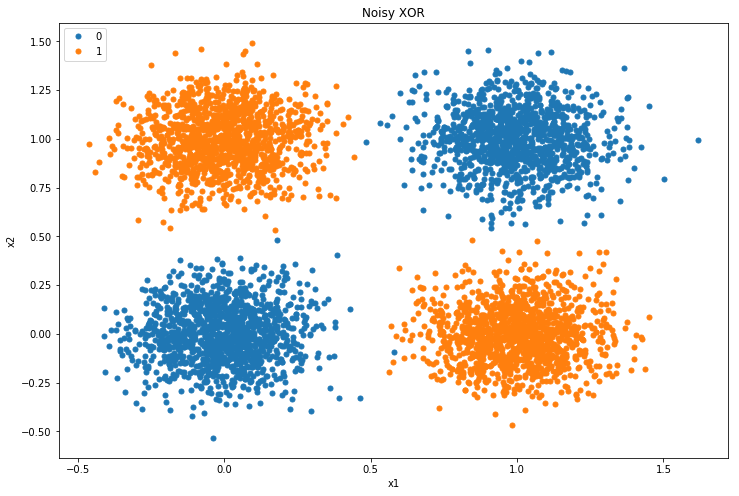

In [77]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [5]:
# Add a dimension for the bias
# X = np.c_[X, np.ones(X.shape[0])]

In [6]:
def next_batch(X, y, batch_size = 100):
    n = X.shape[0]
    idx = np.arange(n)
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    return X[idx, :], y[idx, :]

In [7]:
def relu(a):
    a[a < 0] = 0
    return a

def leaky_relu(a, eps):
    a[np.where(a < 0)] *= eps
    return a

In [8]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [9]:
def softplus(data, labels, a):
    loss = np.multiply(1 - 2*labels, a)
    loss = np.log(1 + np.exp(loss))
    return loss

In [28]:
class Network():
    def __init__(self, hidden_units = 3, lr = 0.1,
                 batch_size = 100, debug = False):

        # Network specifications
        self.hidden_units = hidden_units
        self.batch_size = batch_size
        self.lr = lr
        self.debug = debug
        
        # Initialize network parameters
        w1 = np.random.rand(hidden_units, X.shape[1]) - 0.5
        w2 = np.random.rand(y.shape[1], hidden_units) - 0.5
        b1 = np.zeros((hidden_units, 1))
        b2 = np.zeros((y.shape[1], 1))
        
        self.weights = [w1, w2]
        self.bias = [b1, b2]
        
        # Initialize batchwise layer outputs as empty
        self.linear1 = []
        self.relu1 = []
        self.eps = 0.01
        self.linear2 = []
        
        # Initialize batchwise gradients as empty
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
    
    # Feedforward for entire batch
    def forward(self, data):
        self.linear1 = []
        self.relu1 = []
        self.linear2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::].T
            self._forward(x, idx)
        return np.array(self.linear2)
    
    # Feedforward for a single data point
    def _forward(self, x, idx):
        linear1 = np.dot(self.weights[0], x) + self.bias[0]
        relu1 = leaky_relu(linear1, self.eps)
        linear2 = np.dot(self.weights[1], relu1) + self.bias[1]
        
        self.linear1.append(linear1)
        self.relu1.append(relu1)
        self.linear2.append(linear2)
        
        if self.debug and idx == 0:
            print("\n---- PRINT FORWARD DATA ----\n")
            print("linear1 = ", linear1)
            print("relu1 = ", relu1)
            print("linear2 = ", linear2)
        
        return linear2
        
    # Backprop for entire batch
    def backward(self, L, data, labels):
        if (data.shape[0] != labels.shape[0]):
            print("Data and labels shapes mismatch")
            return None
        
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::].T
            y = labels[idx]
            self._backward(L, x, y, idx)

        self.grad_weights = [np.mean(self.allgrad_weight1),
                             np.mean(self.allgrad_weight2)]
        self.grad_bias = [np.mean(self.allgrad_bias1),
                          np.mean(self.allgrad_bias2)]
        
    # Backprop for a single data point
    def _backward(self, L, x, y, idx):
        r = 1.0 - 2*y
        grad_bias2 = sigmoid(r * self.linear2[idx]) * r
        grad_weight2 = np.multiply(grad_bias2, self.relu1[idx])
        grad_relu1 = grad_bias2 * self.weights[1]
        grad_linear1 = grad_relu1.T
        grad_linear1[np.where(self.relu1[idx] <= 0)] *= self.eps
        grad_weight1 = np.dot(grad_linear1, x.T)
        grad_bias1 = grad_linear1
            
        self.allgrad_weight1.append(grad_weight1)
        self.allgrad_weight2.append(grad_weight2)
        self.allgrad_bias1.append(grad_bias1)
        self.allgrad_bias2.append(grad_bias2)
        
        if (self.debug and idx == 0):
            print("\n---- PRINT BACKWARD DATA ----\n")
            print("linear2 = ", self.linear2[idx])
            print("r:", r, "y:", y)
            print("weight2:", self.weights[1])
            print("grad_bias2:", grad_bias2)
            print("grad_weight2:", grad_weight2)
            print("weight1:", self.weights[0])
            print("grad_relu1:", grad_relu1)
            print("grad_linear1:", grad_linear1)
            print("grad_weight1:", grad_weight1)
            print("grad_bias1:", grad_bias1)
    
    # Update mini batch weights
    def update_weights(self):
        self.weights[0] -= (self.lr * self.grad_weights[0])
        self.weights[1] -= (self.lr * self.grad_weights[1])
        self.bias[0] -= (self.lr * self.grad_bias[0])
        self.bias[1] -= (self.lr * self.grad_bias[1])
        
    # Predict labels
    def predict(self, data):
        out = self.forward(data)
        out[out >= 0] = 1
        out[out < 0] = 0
        return out
    
    # Compute accuracy
    def accuracy(self, data, labels):
        predicted_labels = self.predict(data).reshape(-1, 1)
        matches = np.where(predicted_labels == labels)
        return np.sum(labels == predicted_labels) / labels.shape[0] * 100.0

In [23]:
# Split indexes for training and testing
def split_data():
    train_n = X.shape[0]
    test_n = batch_size * 5
    train_n = train_n - test_n
    train_idx = np.arange(train_n)
    test_idx = np.arange(train_n, train_n + test_n)
    print("Split (train/test): (%d/%d)" %(train_n, test_n))
    data, labels = X[train_idx, ::], y[train_idx, ::]
    test_data, test_labels = X[test_idx, ::], y[test_idx, ::]
    return data, labels, test_data, test_labels

In [29]:
# Train an epoch
def train(net, epoch, data, labels):
    train_n = data.shape[0]
    train_idx = np.arange(train_n)
    np.random.shuffle(train_idx)
    
    train_loss = []
    train_acc = []
    for i in tqdm(range(0, train_n, batch_size)):
        batch_idx = train_idx[i:i + batch_size]
        batch_X = data[batch_idx, :]
        batch_y = labels[batch_idx, ::]
        
        # Feedforward
        a = net.forward(batch_X)
        loss = softplus(batch_X, batch_y, a.reshape(batch_size, 1))
        train_loss.append(loss)
        acc = net.accuracy(batch_X, batch_y)
        train_acc.append(acc)
        net.backward(loss, batch_X, batch_y)
        net.update_weights()
    
    print("Epoch %d, Train loss: %.4f" %(epoch, np.mean(train_loss)))
    print("Epoch %d, Train Accuracy: %.4f" %(epoch, np.mean(train_acc)))

In [30]:
# Test validation data
def test(net, test_data, test_labels):
    test_n = test_data.shape[0]
    test_idx = np.arange(test_n)
    test_loss = []
    test_acc = []
    for i in tqdm(range(0, test_n, batch_size)):
        batch_idx = test_idx[i:i + batch_size]
        batch_X = test_data[batch_idx, :]
        test_labels = y[batch_idx, ::]
        a = net.forward(batch_X)
        loss = softplus(batch_X, batch_y, a.reshape(batch_size, 1))
        test_loss.append(loss)
        acc = net3.accuracy(batch_X, batch_y)
        test_acc.append(acc)
        print("Batch %d: %d/%d Accuracy: %f" %(i/batch_size, i, test_n, acc))    

    print("Test loss:", np.mean(test_loss))
    print("Accuracy:", np.mean(test_acc))

Network with 3 hidden units, Accuracy: 91.6%

In [ ]:
# Random initialization that works for network with 3 hidden units
seed = 7930
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 150
hidden_units = 3

# Initialize network
net3 = Network(hidden_units = 3, lr = 0.01, 
              batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data()

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net3, epoch, data, labels)
    
test(net3, test_data, test_labels)

  7%|▋         | 7/95 [00:00<00:01, 69.25it/s]

Random seed: 7930
Split (train/test): (4750/250)


  7%|▋         | 7/95 [00:00<00:01, 65.09it/s]

Epoch 0, Train loss: 0.6953
Epoch 0, Train Accuracy: 66.5263


  5%|▌         | 5/95 [00:00<00:02, 38.79it/s]

Epoch 1, Train loss: 0.6949
Epoch 1, Train Accuracy: 67.8526


  8%|▊         | 8/95 [00:00<00:01, 73.62it/s]

Epoch 2, Train loss: 0.6946
Epoch 2, Train Accuracy: 70.1895


  8%|▊         | 8/95 [00:00<00:01, 76.94it/s]

Epoch 3, Train loss: 0.6942
Epoch 3, Train Accuracy: 72.7579


  7%|▋         | 7/95 [00:00<00:01, 61.24it/s]

Epoch 4, Train loss: 0.6939
Epoch 4, Train Accuracy: 73.9579


  9%|▉         | 9/95 [00:00<00:00, 88.92it/s]

Epoch 5, Train loss: 0.6937
Epoch 5, Train Accuracy: 73.9789


  8%|▊         | 8/95 [00:00<00:01, 76.13it/s]

Epoch 6, Train loss: 0.6934
Epoch 6, Train Accuracy: 74.1053


  8%|▊         | 8/95 [00:00<00:01, 74.59it/s]

Epoch 7, Train loss: 0.6933
Epoch 7, Train Accuracy: 74.1263


  8%|▊         | 8/95 [00:00<00:01, 79.24it/s]

Epoch 8, Train loss: 0.6931
Epoch 8, Train Accuracy: 74.2316


  9%|▉         | 9/95 [00:00<00:01, 82.31it/s]

Epoch 9, Train loss: 0.6929
Epoch 9, Train Accuracy: 74.2316


  9%|▉         | 9/95 [00:00<00:00, 88.22it/s]

Epoch 10, Train loss: 0.6928
Epoch 10, Train Accuracy: 74.2105


  9%|▉         | 9/95 [00:00<00:00, 89.79it/s]

Epoch 11, Train loss: 0.6926
Epoch 11, Train Accuracy: 74.3579


 11%|█         | 10/95 [00:00<00:00, 93.04it/s]

Epoch 12, Train loss: 0.6925
Epoch 12, Train Accuracy: 74.3789


  9%|▉         | 9/95 [00:00<00:01, 82.85it/s]

Epoch 13, Train loss: 0.6924
Epoch 13, Train Accuracy: 74.2737


  6%|▋         | 6/95 [00:00<00:01, 53.74it/s]

Epoch 14, Train loss: 0.6923
Epoch 14, Train Accuracy: 74.3368


  7%|▋         | 7/95 [00:00<00:01, 63.59it/s]

Epoch 15, Train loss: 0.6921
Epoch 15, Train Accuracy: 73.8316


  7%|▋         | 7/95 [00:00<00:01, 68.97it/s]

Epoch 16, Train loss: 0.6920
Epoch 16, Train Accuracy: 74.3158


  7%|▋         | 7/95 [00:00<00:01, 65.16it/s]

Epoch 17, Train loss: 0.6919
Epoch 17, Train Accuracy: 74.3368


  7%|▋         | 7/95 [00:00<00:01, 62.30it/s]

Epoch 18, Train loss: 0.6918
Epoch 18, Train Accuracy: 74.3158


  6%|▋         | 6/95 [00:00<00:01, 58.50it/s]

Epoch 19, Train loss: 0.6917
Epoch 19, Train Accuracy: 74.2105


  7%|▋         | 7/95 [00:00<00:01, 60.11it/s]

Epoch 20, Train loss: 0.6915
Epoch 20, Train Accuracy: 74.1263


  7%|▋         | 7/95 [00:00<00:01, 68.90it/s]

Epoch 21, Train loss: 0.6914
Epoch 21, Train Accuracy: 74.2526


  7%|▋         | 7/95 [00:00<00:01, 67.99it/s]

Epoch 22, Train loss: 0.6913
Epoch 22, Train Accuracy: 74.2316


  8%|▊         | 8/95 [00:00<00:01, 73.10it/s]

Epoch 23, Train loss: 0.6912
Epoch 23, Train Accuracy: 74.2526


  5%|▌         | 5/95 [00:00<00:02, 41.41it/s]

Epoch 24, Train loss: 0.6911
Epoch 24, Train Accuracy: 74.2316


  7%|▋         | 7/95 [00:00<00:01, 68.85it/s]

Epoch 25, Train loss: 0.6909
Epoch 25, Train Accuracy: 74.2105


  7%|▋         | 7/95 [00:00<00:01, 66.56it/s]

Epoch 26, Train loss: 0.6908
Epoch 26, Train Accuracy: 74.2105


  7%|▋         | 7/95 [00:00<00:01, 65.35it/s]

Epoch 27, Train loss: 0.6907
Epoch 27, Train Accuracy: 74.0211


  8%|▊         | 8/95 [00:00<00:01, 72.53it/s]

Epoch 28, Train loss: 0.6906
Epoch 28, Train Accuracy: 74.0000


  7%|▋         | 7/95 [00:00<00:01, 66.20it/s]

Epoch 29, Train loss: 0.6905
Epoch 29, Train Accuracy: 74.1263


  7%|▋         | 7/95 [00:00<00:01, 67.07it/s]

Epoch 30, Train loss: 0.6904
Epoch 30, Train Accuracy: 74.1263


  5%|▌         | 5/95 [00:00<00:01, 45.69it/s]

Epoch 31, Train loss: 0.6902
Epoch 31, Train Accuracy: 74.0000


  8%|▊         | 8/95 [00:00<00:01, 71.35it/s]

Epoch 32, Train loss: 0.6901
Epoch 32, Train Accuracy: 73.8316


  7%|▋         | 7/95 [00:00<00:01, 63.55it/s]

Epoch 33, Train loss: 0.6900
Epoch 33, Train Accuracy: 73.8316


  7%|▋         | 7/95 [00:00<00:01, 66.87it/s]

Epoch 34, Train loss: 0.6899
Epoch 34, Train Accuracy: 74.1263


  7%|▋         | 7/95 [00:00<00:01, 67.96it/s]

Epoch 35, Train loss: 0.6898
Epoch 35, Train Accuracy: 73.8947


  5%|▌         | 5/95 [00:00<00:01, 49.94it/s]

Epoch 36, Train loss: 0.6896
Epoch 36, Train Accuracy: 73.4737


 11%|█         | 10/95 [00:00<00:00, 95.88it/s]

Epoch 37, Train loss: 0.6895
Epoch 37, Train Accuracy: 73.7053


 11%|█         | 10/95 [00:00<00:00, 93.46it/s]

Epoch 38, Train loss: 0.6894
Epoch 38, Train Accuracy: 73.6421


 11%|█         | 10/95 [00:00<00:00, 91.87it/s]

Epoch 39, Train loss: 0.6893
Epoch 39, Train Accuracy: 73.2632


 11%|█         | 10/95 [00:00<00:00, 90.65it/s]

Epoch 40, Train loss: 0.6892
Epoch 40, Train Accuracy: 73.0947


 11%|█         | 10/95 [00:00<00:00, 92.48it/s]

Epoch 41, Train loss: 0.6890
Epoch 41, Train Accuracy: 73.3053


 11%|█         | 10/95 [00:00<00:00, 91.79it/s]

Epoch 42, Train loss: 0.6889
Epoch 42, Train Accuracy: 73.7263


 11%|█         | 10/95 [00:00<00:00, 95.96it/s]

Epoch 43, Train loss: 0.6888
Epoch 43, Train Accuracy: 72.9053


 12%|█▏        | 11/95 [00:00<00:00, 101.27it/s]

Epoch 44, Train loss: 0.6887
Epoch 44, Train Accuracy: 72.8000


 11%|█         | 10/95 [00:00<00:00, 93.03it/s]

Epoch 45, Train loss: 0.6886
Epoch 45, Train Accuracy: 72.8211


 11%|█         | 10/95 [00:00<00:00, 93.23it/s]

Epoch 46, Train loss: 0.6884
Epoch 46, Train Accuracy: 72.7368


  9%|▉         | 9/95 [00:00<00:00, 89.43it/s]

Epoch 47, Train loss: 0.6883
Epoch 47, Train Accuracy: 72.6947


 11%|█         | 10/95 [00:00<00:00, 97.15it/s]

Epoch 48, Train loss: 0.6882
Epoch 48, Train Accuracy: 72.9684


 11%|█         | 10/95 [00:00<00:00, 92.76it/s]

Epoch 49, Train loss: 0.6881
Epoch 49, Train Accuracy: 72.8421


  9%|▉         | 9/95 [00:00<00:00, 87.66it/s]

Epoch 50, Train loss: 0.6880
Epoch 50, Train Accuracy: 72.4632


 11%|█         | 10/95 [00:00<00:00, 91.45it/s]

Epoch 51, Train loss: 0.6879
Epoch 51, Train Accuracy: 73.0737


 11%|█         | 10/95 [00:00<00:00, 98.43it/s]

Epoch 52, Train loss: 0.6877
Epoch 52, Train Accuracy: 72.8421


 11%|█         | 10/95 [00:00<00:00, 91.27it/s]

Epoch 53, Train loss: 0.6876
Epoch 53, Train Accuracy: 71.7474


 11%|█         | 10/95 [00:00<00:00, 95.43it/s]

Epoch 54, Train loss: 0.6875
Epoch 54, Train Accuracy: 72.4842


  9%|▉         | 9/95 [00:00<00:01, 84.65it/s]

Epoch 55, Train loss: 0.6874
Epoch 55, Train Accuracy: 71.9158


  9%|▉         | 9/95 [00:00<00:01, 82.15it/s]

Epoch 56, Train loss: 0.6873
Epoch 56, Train Accuracy: 71.3895


 11%|█         | 10/95 [00:00<00:00, 89.59it/s]

Epoch 57, Train loss: 0.6871
Epoch 57, Train Accuracy: 71.2000


 11%|█         | 10/95 [00:00<00:00, 96.36it/s]

Epoch 58, Train loss: 0.6870
Epoch 58, Train Accuracy: 71.8737


 11%|█         | 10/95 [00:00<00:00, 92.36it/s]

Epoch 59, Train loss: 0.6869
Epoch 59, Train Accuracy: 71.8316


  9%|▉         | 9/95 [00:00<00:00, 88.31it/s]

Epoch 60, Train loss: 0.6868
Epoch 60, Train Accuracy: 71.3684


 11%|█         | 10/95 [00:00<00:00, 99.02it/s]

Epoch 61, Train loss: 0.6867
Epoch 61, Train Accuracy: 71.9789


 11%|█         | 10/95 [00:00<00:00, 94.65it/s]

Epoch 62, Train loss: 0.6866
Epoch 62, Train Accuracy: 71.7263


 11%|█         | 10/95 [00:00<00:00, 91.02it/s]

Epoch 63, Train loss: 0.6864
Epoch 63, Train Accuracy: 71.3895


 11%|█         | 10/95 [00:00<00:00, 92.78it/s]

Epoch 64, Train loss: 0.6863
Epoch 64, Train Accuracy: 71.5368


  8%|▊         | 8/95 [00:00<00:01, 77.74it/s]

Epoch 65, Train loss: 0.6862
Epoch 65, Train Accuracy: 69.0526


  7%|▋         | 7/95 [00:00<00:01, 64.42it/s]

Epoch 66, Train loss: 0.6861
Epoch 66, Train Accuracy: 71.0737


  6%|▋         | 6/95 [00:00<00:01, 55.94it/s]

Epoch 67, Train loss: 0.6860
Epoch 67, Train Accuracy: 69.1158


  7%|▋         | 7/95 [00:00<00:01, 68.25it/s]

Epoch 68, Train loss: 0.6858
Epoch 68, Train Accuracy: 68.7368


  6%|▋         | 6/95 [00:00<00:01, 58.31it/s]

Epoch 69, Train loss: 0.6857
Epoch 69, Train Accuracy: 71.1789


  8%|▊         | 8/95 [00:00<00:01, 75.11it/s]

Epoch 70, Train loss: 0.6856
Epoch 70, Train Accuracy: 70.0211


  7%|▋         | 7/95 [00:00<00:01, 69.79it/s]

Epoch 71, Train loss: 0.6855
Epoch 71, Train Accuracy: 71.2211


  7%|▋         | 7/95 [00:00<00:01, 62.82it/s]

Epoch 72, Train loss: 0.6854
Epoch 72, Train Accuracy: 69.9579


  8%|▊         | 8/95 [00:00<00:01, 78.03it/s]

Epoch 73, Train loss: 0.6852
Epoch 73, Train Accuracy: 70.2105


  8%|▊         | 8/95 [00:00<00:01, 76.72it/s]

Epoch 74, Train loss: 0.6851
Epoch 74, Train Accuracy: 70.2316


  4%|▍         | 4/95 [00:00<00:02, 39.69it/s]

Epoch 75, Train loss: 0.6850
Epoch 75, Train Accuracy: 68.0632


  5%|▌         | 5/95 [00:00<00:01, 46.07it/s]

Epoch 76, Train loss: 0.6849
Epoch 76, Train Accuracy: 70.2105


  7%|▋         | 7/95 [00:00<00:01, 69.47it/s]

Epoch 77, Train loss: 0.6848
Epoch 77, Train Accuracy: 69.7053


  7%|▋         | 7/95 [00:00<00:01, 65.88it/s]

Epoch 78, Train loss: 0.6847
Epoch 78, Train Accuracy: 69.3263


  7%|▋         | 7/95 [00:00<00:01, 67.23it/s]

Epoch 79, Train loss: 0.6845
Epoch 79, Train Accuracy: 69.2632


  7%|▋         | 7/95 [00:00<00:01, 69.41it/s]

Epoch 80, Train loss: 0.6844
Epoch 80, Train Accuracy: 70.0632


  6%|▋         | 6/95 [00:00<00:01, 56.08it/s]

Epoch 81, Train loss: 0.6843
Epoch 81, Train Accuracy: 67.2842


  7%|▋         | 7/95 [00:00<00:01, 67.25it/s]

Epoch 82, Train loss: 0.6842
Epoch 82, Train Accuracy: 68.4000


  8%|▊         | 8/95 [00:00<00:01, 71.96it/s]

Epoch 83, Train loss: 0.6841
Epoch 83, Train Accuracy: 69.0105


  8%|▊         | 8/95 [00:00<00:01, 74.98it/s]

Epoch 84, Train loss: 0.6840
Epoch 84, Train Accuracy: 67.8737


  6%|▋         | 6/95 [00:00<00:01, 58.59it/s]

Epoch 85, Train loss: 0.6838
Epoch 85, Train Accuracy: 68.6105


  7%|▋         | 7/95 [00:00<00:01, 63.21it/s]

Epoch 86, Train loss: 0.6837
Epoch 86, Train Accuracy: 68.9053


  8%|▊         | 8/95 [00:00<00:01, 79.53it/s]

Epoch 87, Train loss: 0.6836
Epoch 87, Train Accuracy: 67.0526


  7%|▋         | 7/95 [00:00<00:01, 62.44it/s]

Epoch 88, Train loss: 0.6835
Epoch 88, Train Accuracy: 67.5368


  7%|▋         | 7/95 [00:00<00:01, 65.39it/s]

Epoch 89, Train loss: 0.6834
Epoch 89, Train Accuracy: 66.5053


  7%|▋         | 7/95 [00:00<00:01, 58.75it/s]

Epoch 90, Train loss: 0.6833
Epoch 90, Train Accuracy: 67.3474


  7%|▋         | 7/95 [00:00<00:01, 66.15it/s]

Epoch 91, Train loss: 0.6831
Epoch 91, Train Accuracy: 67.6632


  7%|▋         | 7/95 [00:00<00:01, 61.06it/s]

Epoch 92, Train loss: 0.6830
Epoch 92, Train Accuracy: 67.0316


  7%|▋         | 7/95 [00:00<00:01, 67.49it/s]

Epoch 93, Train loss: 0.6829
Epoch 93, Train Accuracy: 68.2105


  5%|▌         | 5/95 [00:00<00:01, 46.54it/s]

Epoch 94, Train loss: 0.6828
Epoch 94, Train Accuracy: 67.6000


 38%|███▊      | 36/95 [00:00<00:00, 66.62it/s]

In [222]:
seed = int(np.random.rand(1) * 10000)
# seed = 4983
print("Random seed:", seed)
np.random.seed(seed)

batch_size = 100
num_epochs = 150
net = Network(hidden_units = 16, lr = 0.001, 
              batch_size = batch_size, debug = False)
n = X.shape[0]
test_n = batch_size * 5
n = n - test_n
print(n, test_n)


idx = np.arange(n)
test_idx = np.arange(n, n + test_n)

# Training
for epoch in range(num_epochs):
    np.random.shuffle(idx)
    train_loss = []
    train_acc = []
    for i in tqdm(range(0, n, batch_size)):
        batch_idx = idx[i:i + batch_size]
        data = X[batch_idx, :]
        labels = y[batch_idx, ::]
        a = net.forward(data)
        loss = softplus(data, labels, a.reshape(batch_size, 1))
        train_loss.append(loss)
        acc = net.accuracy(data, labels)
        train_acc.append(acc)
        net.backward(loss, data, labels)
        net.update_weights()
    print("Epoch %d, Train loss: %.4f" %(epoch, np.mean(train_loss)))
    print("Epoch %d, Train Accuracy: %.4f" %(epoch, np.mean(train_acc)))
    
# Testing
test_loss = []
test_acc = []
for i in tqdm(range(0, test_n, batch_size)):
    batch_idx = test_idx[i:i + batch_size]
    test_data = X[batch_idx, :]
    test_labels = y[batch_idx, ::]
    a = net.forward(test_data)
    loss = softplus(test_data, test_labels, a.reshape(batch_size, 1))
    test_loss.append(loss)
    acc = net.accuracy(test_data, test_labels)
    test_acc.append(acc)
    print("%d/%d Accuracy: %f" %(i, test_n, acc))


print("Test loss:", np.mean(test_loss))
print("Accuracy:", np.mean(test_acc))
    

  9%|▉         | 4/45 [00:00<00:01, 32.75it/s]

Random seed: 4983
4500 500


  9%|▉         | 4/45 [00:00<00:01, 30.12it/s]

Epoch 0, Train loss: 0.6947
Epoch 0, Train Accuracy: 56.2444


  9%|▉         | 4/45 [00:00<00:01, 35.28it/s]

Epoch 1, Train loss: 0.6942
Epoch 1, Train Accuracy: 57.2444


  7%|▋         | 3/45 [00:00<00:01, 25.68it/s]

Epoch 2, Train loss: 0.6936
Epoch 2, Train Accuracy: 58.2889


  9%|▉         | 4/45 [00:00<00:01, 30.72it/s]

Epoch 3, Train loss: 0.6931
Epoch 3, Train Accuracy: 59.0000


  9%|▉         | 4/45 [00:00<00:01, 34.97it/s]

Epoch 4, Train loss: 0.6926
Epoch 4, Train Accuracy: 59.8222


  9%|▉         | 4/45 [00:00<00:01, 32.66it/s]

Epoch 5, Train loss: 0.6921
Epoch 5, Train Accuracy: 60.7333


  9%|▉         | 4/45 [00:00<00:01, 32.34it/s]

Epoch 6, Train loss: 0.6917
Epoch 6, Train Accuracy: 61.3333


 11%|█         | 5/45 [00:00<00:00, 40.14it/s]

Epoch 7, Train loss: 0.6912
Epoch 7, Train Accuracy: 62.0667


 11%|█         | 5/45 [00:00<00:00, 45.53it/s]

Epoch 8, Train loss: 0.6908
Epoch 8, Train Accuracy: 62.7556


 11%|█         | 5/45 [00:00<00:00, 41.66it/s]

Epoch 9, Train loss: 0.6903
Epoch 9, Train Accuracy: 63.4222


 11%|█         | 5/45 [00:00<00:00, 40.67it/s]

Epoch 10, Train loss: 0.6899
Epoch 10, Train Accuracy: 64.2000


 11%|█         | 5/45 [00:00<00:00, 45.42it/s]

Epoch 11, Train loss: 0.6895
Epoch 11, Train Accuracy: 64.6667


 11%|█         | 5/45 [00:00<00:00, 45.46it/s]

Epoch 12, Train loss: 0.6891
Epoch 12, Train Accuracy: 65.3333


 11%|█         | 5/45 [00:00<00:00, 48.18it/s]

Epoch 13, Train loss: 0.6887
Epoch 13, Train Accuracy: 65.9333


  9%|▉         | 4/45 [00:00<00:01, 37.43it/s]

Epoch 14, Train loss: 0.6883
Epoch 14, Train Accuracy: 66.4667


 11%|█         | 5/45 [00:00<00:00, 48.25it/s]

Epoch 15, Train loss: 0.6880
Epoch 15, Train Accuracy: 67.0667


 11%|█         | 5/45 [00:00<00:00, 45.26it/s]

Epoch 16, Train loss: 0.6876
Epoch 16, Train Accuracy: 67.4444


 11%|█         | 5/45 [00:00<00:00, 41.74it/s]

Epoch 17, Train loss: 0.6873
Epoch 17, Train Accuracy: 67.8444


  9%|▉         | 4/45 [00:00<00:01, 38.86it/s]

Epoch 18, Train loss: 0.6870
Epoch 18, Train Accuracy: 68.2444


  9%|▉         | 4/45 [00:00<00:01, 38.46it/s]

Epoch 19, Train loss: 0.6866
Epoch 19, Train Accuracy: 68.5333


  9%|▉         | 4/45 [00:00<00:01, 37.44it/s]

Epoch 20, Train loss: 0.6863
Epoch 20, Train Accuracy: 68.9111


  9%|▉         | 4/45 [00:00<00:01, 36.41it/s]

Epoch 21, Train loss: 0.6860
Epoch 21, Train Accuracy: 69.1778


  9%|▉         | 4/45 [00:00<00:01, 38.13it/s]

Epoch 22, Train loss: 0.6857
Epoch 22, Train Accuracy: 69.4889


  9%|▉         | 4/45 [00:00<00:01, 38.96it/s]

Epoch 23, Train loss: 0.6854
Epoch 23, Train Accuracy: 69.6889


  9%|▉         | 4/45 [00:00<00:01, 37.80it/s]

Epoch 24, Train loss: 0.6852
Epoch 24, Train Accuracy: 69.9333


  9%|▉         | 4/45 [00:00<00:01, 37.71it/s]

Epoch 25, Train loss: 0.6849
Epoch 25, Train Accuracy: 70.1333


  9%|▉         | 4/45 [00:00<00:01, 36.53it/s]

Epoch 26, Train loss: 0.6846
Epoch 26, Train Accuracy: 70.2444


  9%|▉         | 4/45 [00:00<00:01, 37.80it/s]

Epoch 27, Train loss: 0.6844
Epoch 27, Train Accuracy: 70.3111


  9%|▉         | 4/45 [00:00<00:01, 30.75it/s]

Epoch 28, Train loss: 0.6841
Epoch 28, Train Accuracy: 70.5333


  9%|▉         | 4/45 [00:00<00:01, 36.95it/s]

Epoch 29, Train loss: 0.6839
Epoch 29, Train Accuracy: 70.6000


  9%|▉         | 4/45 [00:00<00:01, 37.05it/s]

Epoch 30, Train loss: 0.6836
Epoch 30, Train Accuracy: 70.6000


  9%|▉         | 4/45 [00:00<00:01, 36.90it/s]

Epoch 31, Train loss: 0.6834
Epoch 31, Train Accuracy: 70.7111


  9%|▉         | 4/45 [00:00<00:01, 35.08it/s]

Epoch 32, Train loss: 0.6832
Epoch 32, Train Accuracy: 70.5778


  9%|▉         | 4/45 [00:00<00:01, 35.43it/s]

Epoch 33, Train loss: 0.6830
Epoch 33, Train Accuracy: 70.3556


  4%|▍         | 2/45 [00:00<00:02, 17.17it/s]

Epoch 34, Train loss: 0.6827
Epoch 34, Train Accuracy: 70.1111


  9%|▉         | 4/45 [00:00<00:01, 38.37it/s]

Epoch 35, Train loss: 0.6825
Epoch 35, Train Accuracy: 70.0667


  7%|▋         | 3/45 [00:00<00:01, 28.71it/s]

Epoch 36, Train loss: 0.6823
Epoch 36, Train Accuracy: 69.9556


  9%|▉         | 4/45 [00:00<00:01, 37.19it/s]

Epoch 37, Train loss: 0.6821
Epoch 37, Train Accuracy: 69.7556


  9%|▉         | 4/45 [00:00<00:01, 35.72it/s]

Epoch 38, Train loss: 0.6819
Epoch 38, Train Accuracy: 69.4889


  7%|▋         | 3/45 [00:00<00:01, 29.17it/s]

Epoch 39, Train loss: 0.6818
Epoch 39, Train Accuracy: 69.4444


  7%|▋         | 3/45 [00:00<00:01, 25.63it/s]

Epoch 40, Train loss: 0.6816
Epoch 40, Train Accuracy: 69.2444


  7%|▋         | 3/45 [00:00<00:01, 28.39it/s]

Epoch 41, Train loss: 0.6814
Epoch 41, Train Accuracy: 69.1333


 11%|█         | 5/45 [00:00<00:00, 44.82it/s]

Epoch 42, Train loss: 0.6812
Epoch 42, Train Accuracy: 69.0000


 11%|█         | 5/45 [00:00<00:00, 43.53it/s]

Epoch 43, Train loss: 0.6811
Epoch 43, Train Accuracy: 68.7556


 11%|█         | 5/45 [00:00<00:00, 44.62it/s]

Epoch 44, Train loss: 0.6809
Epoch 44, Train Accuracy: 68.3778


 11%|█         | 5/45 [00:00<00:00, 46.01it/s]

Epoch 45, Train loss: 0.6808
Epoch 45, Train Accuracy: 67.9111


 11%|█         | 5/45 [00:00<00:00, 47.87it/s]

Epoch 46, Train loss: 0.6806
Epoch 46, Train Accuracy: 67.7778


 11%|█         | 5/45 [00:00<00:00, 47.26it/s]

Epoch 47, Train loss: 0.6805
Epoch 47, Train Accuracy: 67.3111


 11%|█         | 5/45 [00:00<00:00, 49.06it/s]

Epoch 48, Train loss: 0.6803
Epoch 48, Train Accuracy: 67.0000


 11%|█         | 5/45 [00:00<00:00, 47.93it/s]

Epoch 49, Train loss: 0.6802
Epoch 49, Train Accuracy: 66.5778


 11%|█         | 5/45 [00:00<00:00, 44.92it/s]

Epoch 50, Train loss: 0.6800
Epoch 50, Train Accuracy: 66.2000


 11%|█         | 5/45 [00:00<00:00, 46.10it/s]

Epoch 51, Train loss: 0.6799
Epoch 51, Train Accuracy: 65.9333


 11%|█         | 5/45 [00:00<00:00, 46.91it/s]

Epoch 52, Train loss: 0.6798
Epoch 52, Train Accuracy: 65.6222


 11%|█         | 5/45 [00:00<00:00, 48.21it/s]

Epoch 53, Train loss: 0.6797
Epoch 53, Train Accuracy: 65.6000


 11%|█         | 5/45 [00:00<00:00, 48.66it/s]

Epoch 54, Train loss: 0.6795
Epoch 54, Train Accuracy: 65.4000


 11%|█         | 5/45 [00:00<00:00, 45.23it/s]

Epoch 55, Train loss: 0.6794
Epoch 55, Train Accuracy: 65.1778


 11%|█         | 5/45 [00:00<00:00, 48.80it/s]

Epoch 56, Train loss: 0.6793
Epoch 56, Train Accuracy: 64.9556


 11%|█         | 5/45 [00:00<00:00, 48.54it/s]

Epoch 57, Train loss: 0.6792
Epoch 57, Train Accuracy: 64.6889


 11%|█         | 5/45 [00:00<00:00, 47.70it/s]

Epoch 58, Train loss: 0.6791
Epoch 58, Train Accuracy: 64.3333


 11%|█         | 5/45 [00:00<00:00, 48.51it/s]

Epoch 59, Train loss: 0.6790
Epoch 59, Train Accuracy: 63.9111


 11%|█         | 5/45 [00:00<00:00, 45.46it/s]

Epoch 60, Train loss: 0.6789
Epoch 60, Train Accuracy: 63.4889


 11%|█         | 5/45 [00:00<00:00, 48.37it/s]

Epoch 61, Train loss: 0.6788
Epoch 61, Train Accuracy: 62.9333


 11%|█         | 5/45 [00:00<00:00, 44.51it/s]

Epoch 62, Train loss: 0.6787
Epoch 62, Train Accuracy: 62.5778


 11%|█         | 5/45 [00:00<00:00, 49.51it/s]

Epoch 63, Train loss: 0.6786
Epoch 63, Train Accuracy: 62.2000


 11%|█         | 5/45 [00:00<00:00, 46.33it/s]

Epoch 64, Train loss: 0.6785
Epoch 64, Train Accuracy: 61.9111


 11%|█         | 5/45 [00:00<00:00, 47.12it/s]

Epoch 65, Train loss: 0.6785
Epoch 65, Train Accuracy: 61.6444


  9%|▉         | 4/45 [00:00<00:01, 38.49it/s]

Epoch 66, Train loss: 0.6784
Epoch 66, Train Accuracy: 61.2000


 11%|█         | 5/45 [00:00<00:00, 47.75it/s]

Epoch 67, Train loss: 0.6783
Epoch 67, Train Accuracy: 60.7556


  9%|▉         | 4/45 [00:00<00:01, 37.42it/s]

Epoch 68, Train loss: 0.6782
Epoch 68, Train Accuracy: 60.3111


  9%|▉         | 4/45 [00:00<00:01, 39.02it/s]

Epoch 69, Train loss: 0.6782
Epoch 69, Train Accuracy: 60.0667


  9%|▉         | 4/45 [00:00<00:01, 34.68it/s]

Epoch 70, Train loss: 0.6781
Epoch 70, Train Accuracy: 59.7778


  9%|▉         | 4/45 [00:00<00:01, 38.82it/s]

Epoch 71, Train loss: 0.6780
Epoch 71, Train Accuracy: 59.4444


  9%|▉         | 4/45 [00:00<00:01, 36.67it/s]

Epoch 72, Train loss: 0.6780
Epoch 72, Train Accuracy: 59.2222


  9%|▉         | 4/45 [00:00<00:01, 30.69it/s]

Epoch 73, Train loss: 0.6779
Epoch 73, Train Accuracy: 58.8222


  7%|▋         | 3/45 [00:00<00:01, 26.26it/s]

Epoch 74, Train loss: 0.6778
Epoch 74, Train Accuracy: 58.6444


  7%|▋         | 3/45 [00:00<00:01, 25.35it/s]

Epoch 75, Train loss: 0.6778
Epoch 75, Train Accuracy: 58.3333


  9%|▉         | 4/45 [00:00<00:01, 38.31it/s]

Epoch 76, Train loss: 0.6777
Epoch 76, Train Accuracy: 58.0222


  7%|▋         | 3/45 [00:00<00:01, 21.13it/s]

Epoch 77, Train loss: 0.6777
Epoch 77, Train Accuracy: 57.8222


  7%|▋         | 3/45 [00:00<00:01, 25.28it/s]

Epoch 78, Train loss: 0.6776
Epoch 78, Train Accuracy: 57.5778


  9%|▉         | 4/45 [00:00<00:01, 34.70it/s]

Epoch 79, Train loss: 0.6776
Epoch 79, Train Accuracy: 57.3778


  7%|▋         | 3/45 [00:00<00:01, 29.13it/s]

Epoch 80, Train loss: 0.6775
Epoch 80, Train Accuracy: 57.0889


  9%|▉         | 4/45 [00:00<00:01, 33.19it/s]

Epoch 81, Train loss: 0.6775
Epoch 81, Train Accuracy: 56.9333


 18%|█▊        | 8/45 [00:00<00:01, 36.15it/s]


KeyboardInterrupt: 